# Visualize SVM Using CVXOPT

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from cvxopt import matrix, solvers

In [2]:
p1 = np.array([10,6])
p2 = np.array([8, 4])
pos_samples = np.array([p1, p2])

n1 = np.array([2,2])
n2 = np.array([3,3])
neg_samples = np.array([n1, n2])

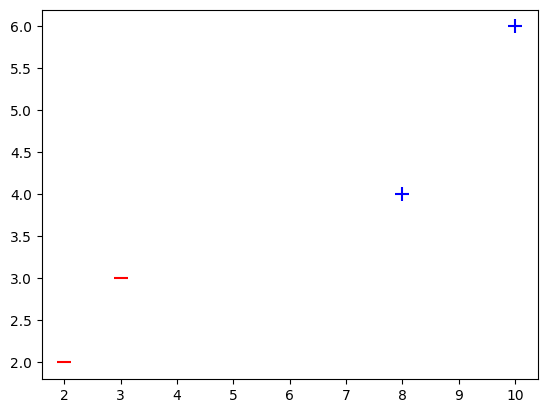

In [3]:
plt.scatter(pos_samples[:,0], pos_samples[:,1], marker='+', color='b', s=100)
plt.scatter(neg_samples[:, 0], neg_samples[:,1], marker='_', color='r',s=100)

plt.show()

In [4]:
# Combine the data
X = np.vstack((pos_samples, neg_samples))
y = np.array([1]*len(pos_samples) + [-1]*len(neg_samples))
X, y = X.astype(float), y.astype(float)
n_samples = X.shape[0]
X, y

(array([[10.,  6.],
        [ 8.,  4.],
        [ 2.,  2.],
        [ 3.,  3.]]),
 array([ 1.,  1., -1., -1.]))

In [6]:
# Formulate the Quadratic Programming Problem
C = 1
P = np.outer(y, y) * np.dot(X, X.T)
P

array([[136., 104., -32., -48.],
       [104.,  80., -24., -36.],
       [-32., -24.,   8.,  12.],
       [-48., -36.,  12.,  18.]])

In [7]:
q = np.ones(n_samples) * -1
q

array([-1., -1., -1., -1.])

In [8]:
G_top = np.diag(np.ones(n_samples) * -1)  # For the alpha_i >= 0 constraints
G_top

array([[-1.,  0.,  0.,  0.],
       [ 0., -1.,  0.,  0.],
       [ 0.,  0., -1.,  0.],
       [ 0.,  0.,  0., -1.]])

In [9]:
G_bottom = np.identity(n_samples)  # For the alpha_i <= C constraints
G_bottom

array([[1., 0., 0., 0.],
       [0., 1., 0., 0.],
       [0., 0., 1., 0.],
       [0., 0., 0., 1.]])

In [10]:
G = np.vstack((G_top, G_bottom))
G

array([[-1.,  0.,  0.,  0.],
       [ 0., -1.,  0.,  0.],
       [ 0.,  0., -1.,  0.],
       [ 0.,  0.,  0., -1.],
       [ 1.,  0.,  0.,  0.],
       [ 0.,  1.,  0.,  0.],
       [ 0.,  0.,  1.,  0.],
       [ 0.,  0.,  0.,  1.]])

In [27]:
# just saving memory for actual implementation
G_test = np.vstack((np.diag(np.ones(n_samples) * -1), np.identity(n_samples)))
G_test == G

array([[ True,  True,  True,  True],
       [ True,  True,  True,  True],
       [ True,  True,  True,  True],
       [ True,  True,  True,  True],
       [ True,  True,  True,  True],
       [ True,  True,  True,  True],
       [ True,  True,  True,  True],
       [ True,  True,  True,  True]])

In [11]:
h = np.hstack((np.zeros(n_samples), np.ones(n_samples) * C))
h  ## matrix(h) results in an 8x1!!

array([0., 0., 0., 0., 1., 1., 1., 1.])

In [12]:
A = matrix(y, (1, n_samples))  # Convert y to a 1xm matrix
matrix_str = str(A)

# Print the entire matrix
print(matrix_str)

[ 1.00e+00  1.00e+00 -1.00e+00 -1.00e+00]



In [13]:
b = matrix(0.0)
b

<1x1 matrix, tc='d'>

In [14]:
# Solve the Quadratic Programming Problem


P, q, G, h = matrix(P), matrix(q), matrix(G), matrix(h)

sol = solvers.qp(P, q, G, h, A, b)

# Extract the Lagrange multipliers
alphas = np.array(sol['x']).flatten()

     pcost       dcost       gap    pres   dres
 0: -1.7648e-01 -5.1480e+00  2e+01  2e+00  3e-15
 1: -7.1452e-02 -2.0926e+00  3e+00  1e-01  2e-15
 2: -4.4233e-02 -2.3180e-01  2e-01  3e-03  4e-15
 3: -7.2741e-02 -8.7626e-02  1e-02  1e-05  9e-16
 4: -7.6734e-02 -7.7106e-02  4e-04  3e-07  8e-16
 5: -7.6921e-02 -7.6925e-02  4e-06  3e-09  2e-16
 6: -7.6923e-02 -7.6923e-02  4e-08  3e-11  8e-16
Optimal solution found.


In [15]:
alphas # higher values at index 1 and 3 are correct, this corresponds to the expected support vectors

array([2.98193445e-09, 7.69230726e-02, 3.50351713e-08, 7.69230406e-02])

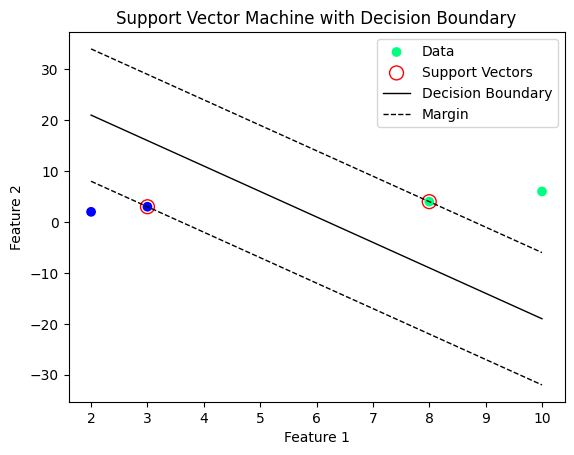

In [16]:
# threshold for identifying support vectors 
threshold = 1e-5

# identify the indices of the support vectors
sv_indices = np.where(alphas > threshold)[0]

# extract support vector coordinates
support_vectors = X[sv_indices]
# Calculate weight vector w
w = np.sum(alphas[:, np.newaxis] * y[:, np.newaxis] * X, axis=0)

# Calculate bias term b (any support vectors will do)
sv = support_vectors[0]
b = y[sv_indices[0]] - np.dot(w, sv)

def decision_boundary_line(x):
    return (-w[0] * x - b) / w[1]

def margin_line(x, margin):
    return (-w[0] * x - b + margin) / w[1]

# Create a range of values for plotting the lines
x_range = np.linspace(X[:, 0].min(), X[:, 0].max(), 100)

# plot original data and support vectors
plt.scatter(X[:, 0], X[:, 1], c=y, cmap='winter', marker='o', label='Data')
plt.scatter(support_vectors[:, 0], support_vectors[:, 1], s=100, facecolors='none', edgecolors='r', marker='o', label='Support Vectors')

# Plot decision boundary and margins
plt.plot(x_range, decision_boundary_line(x_range), 'k-', lw=1, label='Decision Boundary')
plt.plot(x_range, margin_line(x_range, 1), 'k--', lw=1, label='Margin')
plt.plot(x_range, margin_line(x_range, -1), 'k--', lw=1)

# Additional plot settings
plt.xlabel('Feature 1')
plt.ylabel('Feature 2')
plt.title('Support Vector Machine with Decision Boundary')
plt.legend()

# Show the plot
plt.show()

## Let's Try it With Multiple Support Vectors.

In [17]:
p1 = np.array([7,5])
p2 = np.array([4,14])
p3 = np.array([8, 4])
pos_samples = np.array([p1, p2, p3])

n1 = np.array([4,4])
n2 = np.array([2,2])
n3 = np.array([3,3])
neg_samples = np.array([n1, n2, n3])

In [18]:
# Combine the data
X = np.vstack((pos_samples, neg_samples))
y = np.array([1]*len(pos_samples) + [-1]*len(neg_samples))
X, y = X.astype(float), y.astype(float)
n_samples = X.shape[0]
X, y

(array([[ 7.,  5.],
        [ 4., 14.],
        [ 8.,  4.],
        [ 4.,  4.],
        [ 2.,  2.],
        [ 3.,  3.]]),
 array([ 1.,  1.,  1., -1., -1., -1.]))

In [21]:
# Formulate the Quadratic Programming Problem
C = 1

P = matrix(np.outer(y, y) * np.dot(X, X.T))
q = matrix(np.ones(n_samples) * -1)
G = matrix(np.vstack((np.diag(np.ones(n_samples) * -1), np.identity(n_samples))))
h = matrix(np.hstack((np.zeros(n_samples), np.ones(n_samples) * C)))
A = matrix(y, (1, n_samples)) 
b = matrix(0.0)

sol = solvers.qp(P, q, G, h, A, b)

# Extract the Lagrange multipliers
alphas = np.array(sol['x']).flatten()

     pcost       dcost       gap    pres   dres
 0: -5.7346e-01 -9.0333e+00  4e+01  2e+00  2e-15
 1: -2.1374e-01 -4.2183e+00  6e+00  1e-01  3e-15
 2: -1.1836e-01 -6.3876e-01  6e-01  1e-02  3e-15
 3: -1.7804e-01 -2.1661e-01  4e-02  2e-04  1e-15
 4: -1.9879e-01 -2.0182e-01  3e-03  1e-05  1e-15
 5: -1.9990e-01 -2.0011e-01  2e-04  2e-07  2e-15
 6: -1.9999e-01 -2.0001e-01  3e-05  2e-16  2e-15
 7: -2.0000e-01 -2.0000e-01  4e-06  2e-16  2e-15
 8: -2.0000e-01 -2.0000e-01  5e-07  2e-16  1e-15
 9: -2.0000e-01 -2.0000e-01  8e-08  2e-16  6e-16
Optimal solution found.


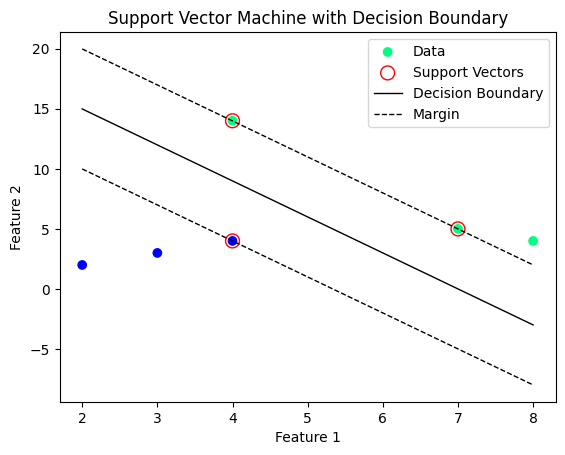

In [22]:
# threshold for identifying support vectors 
threshold = 1e-5

# identify the indices of the support vectors
sv_indices = np.where(alphas > threshold)[0]

# extract support vector coordinates
support_vectors = X[sv_indices]
# Calculate weight vector w
w = np.sum(alphas[:, np.newaxis] * y[:, np.newaxis] * X, axis=0)

# Calculate bias term b (any support vectors will do)
sv = support_vectors[0]
b = y[sv_indices[0]] - np.dot(w, sv)

def decision_boundary_line(x):
    return (-w[0] * x - b) / w[1]

def margin_line(x, margin):
    return (-w[0] * x - b + margin) / w[1]

# Create a range of values for plotting the lines
x_range = np.linspace(X[:, 0].min(), X[:, 0].max(), 100)

# Plot original data and support vectors
plt.scatter(X[:, 0], X[:, 1], c=y, cmap='winter', marker='o', label='Data')
plt.scatter(support_vectors[:, 0], support_vectors[:, 1], s=100, facecolors='none', edgecolors='r', marker='o', label='Support Vectors')

# Plot decision boundary and margins
plt.plot(x_range, decision_boundary_line(x_range), 'k-', lw=1, label='Decision Boundary')
plt.plot(x_range, margin_line(x_range, 1), 'k--', lw=1, label='Margin')
plt.plot(x_range, margin_line(x_range, -1), 'k--', lw=1)

# Additional plot settings
plt.xlabel('Feature 1')
plt.ylabel('Feature 2')
plt.title('Support Vector Machine with Decision Boundary')
plt.legend()

# Show the plot
plt.show()